# Hybrid CNN-LSTM and NLLS for experimental polarization curve

This script applies a hybrid approach combining a previously trained CNN-LSTM model and nonlinear least squares (NLLS) fitting to estimate electrochemical parameters from experimental polarization curves.

First, the experimental current-voltage curve is loaded and pre-processed to check for mass transport limitations. This check is performed by comparing the derivative of the potential with respect to the current along different regions of the curve. If a significant deviation is detected at high currents, the curve is considered to exhibit mass transport limitation (J = 1); otherwise, J = 0.

Depending on the presence of mass transport effects, the script selects the appropriate neural network model (trained either with or without the limiting current parameter iL). The chosen CNN-LSTM model is then loaded and applied to the experimental curve to predict the normalized electrochemical parameters. These predictions are subsequently denormalized to recover their physical values.

For curves with mass transport limitation (J = 1), a post-processing correction is applied to the limiting current density iL. If the relative error between the predicted maximum current and the experimental maximum exceeds 1%, iL is rescaled to match the experimental value. The corresponding corrected polarization curve is generated.

Next, the NN-based parameter estimates are used as initial guesses in a NLLS fit, refining the parameters to improve the agreement with the experimental data. The final fitted parameters are reported along with 95% confidence intervals derived from the covariance matrix of the fit. The agreement between the experimental curve and the final reconstructed curve is quantified using the coefficient of determination $R^2$.

# Library import

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.stats import t

# Perform the algorithm NN+NLLS for parameters estimation

Choose the right model with n_val

In [2]:
n_val = 5

In [3]:
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def R_2(true, pred):
    return r2_score(true, pred)

Load experimental data and evaluate the tipe of curve: with or without mass transport limitation

In [10]:
# Loading of the experimental data
curve = np.loadtxt(f"curve2.txt")

i_vals = curve[:, 0]
E_real = curve[:, 1]
i_max_real = i_vals[-1]

In [11]:
# Check mass transport effect via derivative

# Derivative calculation
mask_valid = ~np.isnan(i_vals) & ~np.isnan(E_real)
i_vals_clean = i_vals[mask_valid]
E_vals_clean = E_real[mask_valid]

dE_di = np.gradient(E_vals_clean, i_vals_clean)

n_points = len(dE_di)
start_second = int(n_points * 0.33)
end_second   = int(n_points * 0.66)

mean_second = np.mean(dE_di[start_second:end_second])
mean_last   = np.mean(dE_di[-2:])

# Compare derivative values to detect limiting current effect ---> use the same tolerance used in 1_NN_dataset_creation
tol = 5e-5

if abs(abs(mean_last) - abs(mean_second)) > tol and abs(mean_last) > abs(mean_second):
    mass_transport = True
    J = 1
else:
    mass_transport = False
    J = 0

print(f"Mass transport effect detected: {mass_transport} → J = {J}")

Mass transport effect detected: False → J = 0


Upload the right NN model

In [15]:
if J == 1:
    model_path = f"CNN_LSTM_noregu_{n_val}val_withiL.keras"
    params_path = f'params_with_iL_{n_val}.npy'
    config_msg = "Model WITH iL"
else:
    model_path = f"CNN_LSTM_noregu_{n_val}val_withoutiL.keras"
    params_path = f"params_without_iL_{n_val}.npy"
    config_msg = "Model WITHOUT iL"

# carico UNA SOLA VOLTA
model = load_model(model_path, custom_objects={'r2_metric': r2_metric})
parameters = np.load(params_path)

print(f"{config_msg}")

Model WITHOUT iL


Perform the algorithm NN+NLLS for parameters estimation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
NN estimated parameters:
E0 = 1.4570732772111894
b = 73.894977953434
i0 = 347.43673953771594
R = 6.588161405324936


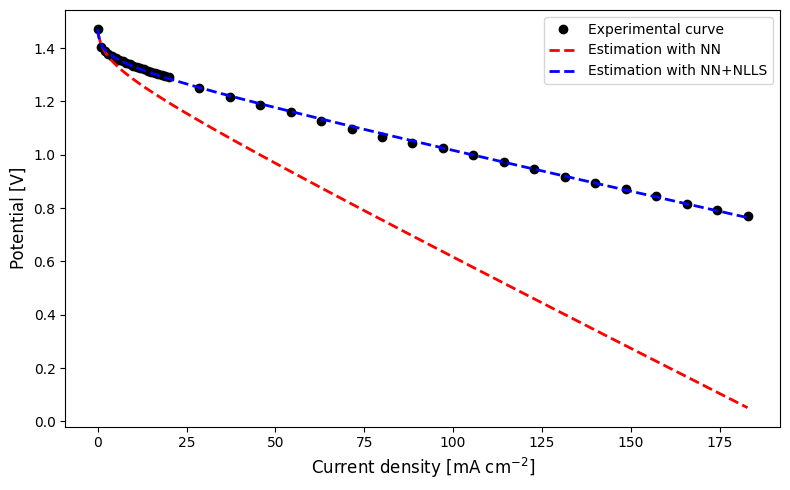


Final estimates wiht 95% CI:
E0 (V)       = 1.471767 ± 0.009553  (CI: [1.462214, 1.481321])
b (mV/dec)   = 57.328048 ± 5.707461  (CI: [51.620587, 63.035509])
i0 (µA/cm²)  = 112.650615 ± 65.881005  (CI: [46.769610, 178.531620])
R (Ohm·cm²)  = 2.862141 ± 0.058871  (CI: [2.803269, 2.921012])

R² between real and final estiamted curve: 0.999502


In [13]:
if J == 1:

    # i-V model and metrics
    def E(i, E0, b, i0, R, iL):
        return (E0 - b * np.log(0.5 * ((i / i0) + np.sqrt((i / i0)**2 + 4))) - R * i + 1 / (i - iL))

    # NN prediction
    curva_test = np.expand_dims(curve, axis=0)
    pred_normalized = model.predict(curva_test)

    min_params = np.min(parameters, axis=0)
    max_params = np.max(parameters, axis=0)

    predicted_params = (pred_normalized * (max_params - min_params) + min_params).flatten()
    E0_pred, b_pred, i0_pred, R_pred, iL_pred = predicted_params

    # NN predicted curve
    i_pred_NN = np.linspace(0, iL_pred * 0.93, 1000)
    E_pred_NN = E(i_pred_NN, *predicted_params)

    # Print NN estimation with correct units
    predicted_params_conv = [E0_pred, b_pred * 1000 * np.log(10), i0_pred * 1000, R_pred * 1000, iL_pred]

    print("NN estimated parameters:")
    for name, val in zip(["E0", "b", "i0", "R", "iL"], predicted_params_conv):
        print(name, "=", val)

    # Post-processing iL
    mask_valid = np.isfinite(E_pred_NN)
    i_max_NN = i_pred_NN[mask_valid][-1]

    rel_err_i = abs(i_max_NN - i_max_real) / i_max_real * 100

    print(f"\ni_max real = {i_max_real:.6f}")
    print(f"i_max NN   = {i_max_NN:.6f}")
    print(f"Δi rel     = {rel_err_i:.2f} %")

    predicted_params_pp = predicted_params.copy()

    if rel_err_i > 1.0:
        scale = i_max_real / i_max_NN
        predicted_params_pp[4] *= scale
        print(
            f"iL NN correction: {iL_pred:.6f} → {predicted_params_pp[4]:.6f}"
        )
    else:
        print("No correction for iL")

    # pp corrected curve
    i_pred_NN_pp = np.linspace(0, predicted_params_pp[4] * 0.93, 1000)
    E_pred_NN_pp = E(i_pred_NN_pp, *predicted_params_pp)

    # NLLS fit
    lower_bounds = [0.0, 0.0, 1e-10, 0.0, 0.0]
    upper_bounds = [2.0, 1.0, 10.0, 10.0, 2000.0]

    def do_fit(p0):
        mask = np.abs(i_vals - p0[4]) > 1e-3
        return curve_fit(E, i_vals[mask], E_real[mask], p0=p0, bounds=(lower_bounds, upper_bounds), maxfev=20000)

    popt_final, pcov_final = do_fit(predicted_params_pp)

    # Fitted curve
    i_pred_fit = np.linspace(0, i_vals[-1], 1000)
    E_pred_fit = E(i_pred_fit, *popt_final)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(i_vals, E_real, 'ko', label="Experimental curve")
    plt.plot(i_pred_NN, E_pred_NN, 'r--', lw=2, label="Estimation with NN")
    plt.plot(i_pred_NN_pp, E_pred_NN_pp, 'g--', lw=2, label="Estimation after i$_{\\mathrm{L}}$-PP")
    plt.plot(i_pred_fit, E_pred_fit, 'b-', lw=2, label="Estimation with NN+NLLS")
    plt.xlabel('Current density [mA cm$^{-2}$]', fontsize=16)
    plt.ylabel('Potential [V]', fontsize=16)
    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    plt.legend(fontsize=12)
    plt.show()

    # Confidence interval (95%)
    popt = popt_final
    pcov = pcov_final

    n_data = len(i_vals)
    p = len(popt)
    dof = max(1, n_data - p)

    perr = np.sqrt(np.abs(np.diag(pcov)))

    alpha = 0.05
    tval = t.ppf(1 - alpha/2, dof)
    ci_lower = popt - tval * perr
    ci_upper = popt + tval * perr

    # Print fitted parameters with correct units
    E0_f, b_f, i0_f, R_f, iL_f = popt
    perr_E0, perr_b, perr_i0, perr_R, perr_iL = perr

    E0_s = E0_f
    b_s  = b_f  * 1000 * np.log(10)
    i0_s = i0_f * 1000
    R_s  = R_f  * 1000
    iL_s = iL_f

    ciL_E0, ciU_E0 = ci_lower[0], ci_upper[0]
    ciL_b,  ciU_b  = ci_lower[1]*1000*np.log(10), ci_upper[1]*1000*np.log(10)
    ciL_i0, ciU_i0 = ci_lower[2]*1000, ci_upper[2]*1000
    ciL_R,  ciU_R  = ci_lower[3]*1000, ci_upper[3]*1000
    ciL_iL, ciU_iL = ci_lower[4], ci_upper[4]

    print("\nFinal estimates wiht 95% CI:")

    param_names = ["E0 (V)", "b (mV/dec)", "i0 (µA/cm²)", "R (Ohm·cm²)", "iL (mA/cm²)"]
    param_vals  = [E0_s, b_s, i0_s, R_s, iL_s]
    param_ciL   = [ciL_E0, ciL_b, ciL_i0, ciL_R, ciL_iL]
    param_ciU   = [ciU_E0, ciU_b, ciU_i0, ciU_R, ciU_iL]

    for name, val, L, U in zip(param_names, param_vals, param_ciL, param_ciU):
        err = (U - L) / 2
        print(f"{name:<12} = {val:.6f} ± {err:.6f}  (CI: [{L:.6f}, {U:.6f}])")

    # R²
    E_fit = E(i_vals, *popt_final)
    R2 = R_2(E_real, E_fit)

    print(f"\nR² between real and final estiamted curve: {R2:.6f}")

    # Saving
    nn_data = np.column_stack((i_pred_NN, E_pred_NN))
    pp_data = np.column_stack((i_pred_NN_pp, E_pred_NN_pp))
    fit_data = np.column_stack((i_pred_fit, E_pred_fit))
    np.savetxt(f"curve1_NN.txt", nn_data, header="i_pred_NN   E_pred_NN", fmt="%.8f")
    np.savetxt(f"curve1_pp.txt", pp_data, header="i_pred_NN_pp   E_pred_NN_pp", fmt="%.8f")
    np.savetxt(f"curve1_NNNLLS.txt", fit_data, header="i_pred_fit   E_pred_fit", fmt="%.8f")


if J == 0:
    # i-V model and metrics
    def E(i, E0, b, i0, R):
        return (E0 - b * np.log(0.5 * ((i / i0) + np.sqrt((i / i0)**2 + 4))) - R * i)

    # NN prediction
    curva_test = np.expand_dims(curve, axis=0)
    pred_normalized = model.predict(curva_test)

    # Take only [E0, b, i0, R]
    parameters = parameters[:, :4]

    min_params = np.min(parameters, axis=0)
    max_params = np.max(parameters, axis=0)

    predicted_params = (pred_normalized * (max_params - min_params) + min_params).flatten()

    E0_pred, b_pred, i0_pred, R_pred = predicted_params

    # NN predicted curve
    i_pred_NN = np.linspace(0, i_vals[-1], 1000)
    E_pred_NN = E(i_pred_NN, *predicted_params)

    # Print NN estimation with correct units
    predicted_params_conv = [E0_pred, b_pred * 1000 * np.log(10), i0_pred * 1000, R_pred * 1000]

    print("NN estimated parameters:")
    for name, val in zip(["E0", "b", "i0", "R"], predicted_params_conv):
        print(name, "=", val)

    # NLLS fit
    lower_bounds = [0.0, 0.0, 1e-10, 0.0]
    upper_bounds = [2.0, 1.0, 10.0, 10.0]

    def do_fit(p0):
        return curve_fit(E, i_vals, E_real, p0=p0, bounds=(lower_bounds, upper_bounds), maxfev=20000)

    popt_final, pcov_final = do_fit(predicted_params)

    # Fitted curve
    i_pred_fit = np.linspace(0, i_vals[-1], 1000)
    E_pred_fit = E(i_pred_fit, *popt_final)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(i_vals, E_real, 'ko', label="Experimental curve")
    plt.plot(i_pred_NN, E_pred_NN, 'r--', lw=2, label="Estimation with NN")
    plt.plot(i_pred_fit, E_pred_fit, 'b--', lw=2, label="Estimation with NN+NLLS")
    plt.xlabel('Current density [mA cm$^{-2}$]', fontsize=12)
    plt.ylabel('Potential [V]', fontsize=12)
    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Confidence interval (95%)
    popt = popt_final
    pcov = pcov_final

    n_data = len(i_vals)
    p = len(popt)
    dof = max(1, n_data - p)

    perr = np.sqrt(np.abs(np.diag(pcov)))

    alpha = 0.05
    tval = t.ppf(1 - alpha/2, dof)
    ci_lower = popt - tval * perr
    ci_upper = popt + tval * perr

    # Print fitted parameters with correct units
    E0_f, b_f, i0_f, R_f = popt
    perr_E0, perr_b, perr_i0, perr_R = perr

    E0_s = E0_f
    b_s  = b_f  * 1000 * np.log(10)
    i0_s = i0_f * 1000
    R_s  = R_f  * 1000

    ciL_E0, ciU_E0 = ci_lower[0], ci_upper[0]
    ciL_b,  ciU_b  = ci_lower[1]*1000*np.log(10), ci_upper[1]*1000*np.log(10)
    ciL_i0, ciU_i0 = ci_lower[2]*1000, ci_upper[2]*1000
    ciL_R,  ciU_R  = ci_lower[3]*1000, ci_upper[3]*1000

    print("\nFinal estimates wiht 95% CI:")

    param_names = ["E0 (V)", "b (mV/dec)", "i0 (µA/cm²)", "R (Ohm·cm²)"]
    param_vals  = [E0_s, b_s, i0_s, R_s]
    param_ciL   = [ciL_E0, ciL_b, ciL_i0, ciL_R]
    param_ciU   = [ciU_E0, ciU_b, ciU_i0, ciU_R]

    for name, val, L, U in zip(param_names, param_vals, param_ciL, param_ciU):
        err = (U - L) / 2
        print(f"{name:<12} = {val:.6f} ± {err:.6f}  (CI: [{L:.6f}, {U:.6f}])")

    # R²
    E_fit = E(i_vals, *popt_final)
    R2 = R_2(E_real, E_fit)

    print(f"\nR² between real and final estiamted curve: {R2:.6f}")

    # Saving
    nn_data = np.column_stack((i_pred_NN, E_pred_NN))
    fit_data = np.column_stack((i_pred_fit, E_pred_fit))
    np.savetxt(f"curve2_NN.txt", nn_data, header="i_pred_NN   E_pred_NN", fmt="%.8f")
    np.savetxt(f"curve2L_NNNLLS.txt", fit_data, header="i_pred_fit   E_pred_fit", fmt="%.8f")